In [0]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
eta=1e-5

## Bernoulli Bandit

We are going to implement several exploration strategies for simplest problem - bernoulli bandit.

The bandit has $K$ actions. Action produce 1.0 reward $r$ with probability $0 \le \theta_k \le 1$ which is unknown to agent, but fixed over time. Agent's objective is to minimize regret over fixed number $T$ of action selections:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

Where $\theta^* = \max_k\{\theta_k\}$

**Real-world analogy:**

Clinical trials - we have $K$ pills and $T$ ill patient. After taking pill, patient is cured with probability $\theta_k$. Task is to find most efficient pill.

A research on clinical trials - https://arxiv.org/pdf/1507.08025.pdf

In [0]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)
        
    @property
    def action_count(self):
        return len(self._probs)
    
    def pull(self, action):
        if np.any(np.random.random() > self._probs[action]):
            return 0.0
        return 1.0
    
    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)
    
    def step(self):
        """ Used in nonstationary version
        """
        pass
    
    def reset(self):
        """ Used in nonstationary version
        """

In [0]:
class AbstractAgent(metaclass=ABCMeta):   
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0
    
    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass
    
    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1
    
    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):    
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Epsilon-greedy agent

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Implement the algorithm above in the cell below:

In [0]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon = 0.01):
        self._epsilon = epsilon

    def get_action(self):
        # YOUR CODE HERE
        action_probs=(self._successes/(self._successes+self._failures+eta))
        return np.random.choice([range(len(self._successes)),np.argmax(action_probs)],p=[self._epsilon,1-self._epsilon])
    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon) 

### UCB Agent
Epsilon-greedy strategy heve no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents otimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

>> **end for** 

>> $x_t \leftarrow argmax_{k}w$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**


__Note:__ in practice, one can multiply $\sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$ by some tunable parameter to regulate agent's optimism and wilingness to abandon non-promising actions.

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [0]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        # YOUR CODE HERE
        action_probs=(self._successes/(self._successes+self._failures+eta))+(np.sqrt((2*np.log(self._total_pulls+eta)/(self._successes+self._failures+eta))))
        return np.argmax(action_probs)
    @property
    def name(self):
        return self.__class__.__name__

### Thompson sampling

UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**
 

More on Tompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [0]:
from scipy.stats import beta

class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        
        action_probs=[]
        for i,theta in enumerate(range(len(self._successes))):
            action_probs.append(np.random.beta(self._successes[i]+eta,self._failures[i]+eta))
        return np.argmax(action_probs)
    @property
    def name(self):
        return self.__class__.__name__

In [0]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


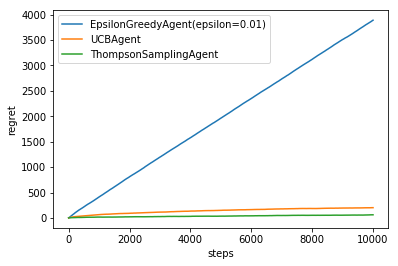

In [63]:
# Uncomment agents
agents = [
     EpsilonGreedyAgent(),
     UCBAgent(),
     ThompsonSamplingAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

In [0]:
# Uncomment agents
agents = [
     #EpsilonGreedyAgent(),
     #UCBAgent(),
     #ThompsonSamplingAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

In [0]:
import re
import requests
import json


class Grader(object):
    def __init__(self, assignment_key, all_parts=()):
        """
        Assignment key is the way to tell Coursera which problem is being submitted.
        """
        self.submission_page = \
            'https://www.coursera.org/api/onDemandProgrammingScriptSubmissions.v1'
        self.assignment_key = assignment_key
        self.answers = {part: None for part in all_parts}

    def submit(self, email, token):
        submission = {
                    "assignmentKey": self.assignment_key,
                    "submitterEmail": email,
                    "secret": token,
                    "parts": {}
        }
        for part, output in self.answers.items():
            if output is not None:
                submission["parts"][part] = {"output": output}
            else:
                submission["parts"][part] = dict()
        request = requests.post(self.submission_page, data=json.dumps(submission))
        response = request.json()
        if request.status_code == 201:
            print('Submitted to Coursera platform. See results on assignment page!')
        elif u'details' in response and u'learnerMessage' in response[u'details']:
            print(response[u'details'][u'learnerMessage'])
        else:
            print("Unknown response from Coursera: {}".format(request.status_code))
            print(response)

    def set_answer(self, part, answer):
        """Adds an answer for submission. Answer is expected either as string, number, or
           an iterable of numbers.
           Args:
              part - str, assignment part id
              answer - answer to submit. If non iterable, appends repr(answer). If string,
                is appended as provided. If an iterable and not string, converted to
                space-delimited repr() of members.
        """
        if isinstance(answer, str):
            self.answers[part] = answer
        else:
            try:
                self.answers[part] = " ".join(map(repr, answer))
            except TypeError:
                self.answers[part] = repr(answer)


def array_to_grader(array, epsilon=1e-4):
    """Utility function to help preparing Coursera grading conditions descriptions.
    Args:
       array: iterable of numbers, the correct answers
       epslion: the generated expression will accept the answers with this absolute difference with
         provided values
    Returns:
       String. A Coursera grader expression that checks whether the user submission is in
         (array - epsilon, array + epsilon)"""
    res = []
    for element in array:
        if isinstance(element, int):
            res.append("[{0}, {0}]".format(element))
        else:
            res.append("({0}, {1})".format(element - epsilon, element + epsilon))
    return " ".join(res)


In [0]:
import sys
sys.path.append("..")

#import grading


def submit_bandits(agents, scores, email, token):
    epsilon_greedy_agent = None
    ucb_agent = None
    thompson_sampling_agent = None

    for agent in agents:
        if "EpsilonGreedyAgent" in agent.name:
            epsilon_greedy_agent = agent.name
        if "UCBAgent" in agent.name:
            ucb_agent = agent.name
        if "ThompsonSamplingAgent" in agent.name:
            thompson_sampling_agent = agent.name

    assert epsilon_greedy_agent is not None
    assert ucb_agent is not None
    assert thompson_sampling_agent is not None

    grader = Grader("VL9tBt7zEeewFg5wtLgZkA")
    grader.set_answer(
        "YQLYE",
        (int(scores[epsilon_greedy_agent][int(1e4) - 1]) -
         int(scores[epsilon_greedy_agent][int(5e3) - 1])))

    grader.set_answer(
        "FCHOZ",
        (int(scores[epsilon_greedy_agent][int(1e4) - 1]) -
         int(scores[ucb_agent][int(1e4) - 1])))

    grader.set_answer(
        "0JWHl",
        (int(scores[epsilon_greedy_agent][int(5e3) - 1]) -
         int(scores[ucb_agent][int(5e3) - 1])))

    grader.set_answer(
        "4rH5M",
        (int(scores[epsilon_greedy_agent][int(1e4) - 1]) -
         int(scores[thompson_sampling_agent][int(1e4) - 1])))

    grader.set_answer(
        "TvOqm",
        (int(scores[epsilon_greedy_agent][int(5e3) - 1]) -
         int(scores[thompson_sampling_agent][int(5e3) - 1])))

    grader.submit(email, token)


### Submit to coursera

In [39]:
#from submit import submit_bandits

submit_bandits(agents, regret, "ss.ghule@ncl.res.in", "o3Ng7ntc94XO3U5K")

Submitted to Coursera platform. See results on assignment page!
